# Machine Learning project a.y. 2021/2022

## Scikit-learn MLPRegressor model

## Importing libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

## Loading training set and blind test set

In [2]:
df_visual = pd.read_csv('./data/ML-CUP21-TR.csv', usecols=[11,12], names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df = pd.read_csv('./data/ML-CUP21-TR.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10', 'x','y'])
df = df[7:] # remove first 7 rows of comments
df_visual = df_visual[7:]

df_blind_ts = pd.read_csv('./data/ML-CUP21-TS.csv', names=['idx','f1','f2','f3','f4','f5','f6','f7','f8','f9','f10'])
df_blind_ts = df_blind_ts[7:]

In [3]:
df_visual

,x,y
7,7.187592,-8.768943
8,0.170888,-25.895562
9,4.167006,-29.062891
10,7.259387,-31.529549
11,5.941430,-30.540759
...,...,...
1479,4.587862,-29.743108
1480,-0.961247,-19.418516
1481,4.247799,-29.460539
1482,-1.417041,-21.391002


In [4]:
df

,idx,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,x,y
7,1,0.248433,-1.801874,-1.116485,1.255230,-1.021899,-1.425146,1.029583,1.261154,-0.185208,-0.618970,7.187592,-8.768943
8,2,0.612246,0.369337,1.119434,-0.689106,0.451776,1.308115,-0.518925,0.129025,-0.558788,1.588863,0.170888,-25.895562
9,3,-0.974871,0.275613,1.106435,-0.867804,0.230839,1.870421,-0.794584,-1.712529,-0.935208,0.109706,4.167006,-29.062891
10,4,-1.493339,1.992164,0.609691,-1.001476,1.268201,0.516364,-0.984814,-1.169440,-0.765422,-0.487069,7.259387,-31.529549
11,5,-0.432028,1.592409,0.853561,-1.365528,1.310392,0.954528,-0.946305,-1.269243,-2.031158,-0.227847,5.941430,-30.540759
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1479,1473,-0.694724,1.184451,1.426530,-1.260271,0.254272,1.588396,-1.015617,-1.269062,-0.738645,0.246257,4.587862,-29.743108
1480,1474,2.088156,0.160464,-1.101186,0.864773,-0.002852,-0.650301,-0.311431,0.152538,0.548056,0.978403,-0.961247,-19.418516
1481,1475,-0.096369,1.599799,0.160111,-1.473405,0.191667,1.389114,-1.265515,-0.833097,-0.747211,0.014422,4.247799,-29.460539
1482,1476,0.417788,-0.062619,0.995768,-0.216366,0.054374,0.822223,-1.585737,-0.182712,0.271711,2.163382,-1.417041,-21.391002


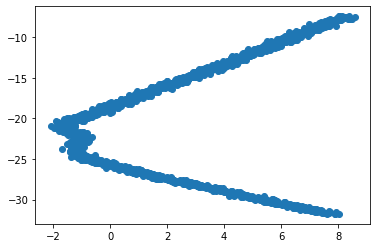

In [5]:
plt.scatter(df_visual['x'], df_visual['y'])

In [6]:
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import train_test_split

In [7]:
label = df[['x','y']]
df.drop(labels=['x','y'], axis=1, inplace=True)
#train_set, test_set, train_label, test_label = train_test_split(adult, label, stratify =label, test_size=0.30)

In [8]:
label

,x,y
7,7.187592,-8.768943
8,0.170888,-25.895562
9,4.167006,-29.062891
10,7.259387,-31.529549
11,5.941430,-30.540759
...,...,...
1479,4.587862,-29.743108
1480,-0.961247,-19.418516
1481,4.247799,-29.460539
1482,-1.417041,-21.391002


In [9]:
df

,idx,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10
7,1,0.248433,-1.801874,-1.116485,1.255230,-1.021899,-1.425146,1.029583,1.261154,-0.185208,-0.618970
8,2,0.612246,0.369337,1.119434,-0.689106,0.451776,1.308115,-0.518925,0.129025,-0.558788,1.588863
9,3,-0.974871,0.275613,1.106435,-0.867804,0.230839,1.870421,-0.794584,-1.712529,-0.935208,0.109706
10,4,-1.493339,1.992164,0.609691,-1.001476,1.268201,0.516364,-0.984814,-1.169440,-0.765422,-0.487069
11,5,-0.432028,1.592409,0.853561,-1.365528,1.310392,0.954528,-0.946305,-1.269243,-2.031158,-0.227847
...,...,...,...,...,...,...,...,...,...,...,...
1479,1473,-0.694724,1.184451,1.426530,-1.260271,0.254272,1.588396,-1.015617,-1.269062,-0.738645,0.246257
1480,1474,2.088156,0.160464,-1.101186,0.864773,-0.002852,-0.650301,-0.311431,0.152538,0.548056,0.978403
1481,1475,-0.096369,1.599799,0.160111,-1.473405,0.191667,1.389114,-1.265515,-0.833097,-0.747211,0.014422
1482,1476,0.417788,-0.062619,0.995768,-0.216366,0.054374,0.822223,-1.585737,-0.182712,0.271711,2.163382


In [10]:
X_train, X_test, y_train, y_test = train_test_split(df, label, random_state=42, test_size=0.30)

In [11]:
regressor = MLPRegressor(random_state=42, max_iter=500).fit(X_train, y_train)

In [19]:
regressor.score(X_test, y_test)

0.8696963705237135

In [13]:
y_pred = regressor.predict(df_blind_ts)

In [17]:
y_pred = pd.DataFrame(data=y_pred, columns=["x", "y"])

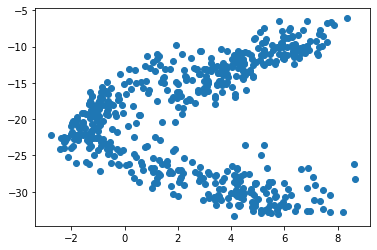

In [18]:
plt.scatter(y_pred['x'], y_pred['y'])

## Grid Search

In [30]:
#to find the best set of parameter setting, we can run a grid search
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from sklearn.metrics import make_scorer
from sklearn.metrics import accuracy_score

#define the parameters' values you want to try
param_dist = {"hidden_layer_sizes": [(100,), (50,), (100, 100), (50,50)],
              "activation": ['identity', 'logistic', 'tanh', 'relu'],
              "solver": ['lbfgs', 'sgd', 'adam'],
              "max_iter": [1000],
             }
#define the number of iterations
n_iter_search = 5
#define the model
regressor = MLPRegressor()
#define the grid search
grid_search = RandomizedSearchCV(regressor, param_distributions=param_dist, 
                            n_iter=n_iter_search, 
                            n_jobs=10, 
                            scoring=make_scorer(accuracy_score))
#run the grid search
grid_search.fit(X_train, y_train)

/home/luca/.local/lib/python3.9/site-packages/sklearn/model_selection/_search.py:969: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan]
  warnings.warn(


RandomizedSearchCV(estimator=MLPRegressor(), n_iter=5, n_jobs=10,
                   param_distributions={'activation': ['identity', 'logistic',
                                                       'tanh', 'relu'],
                                        'hidden_layer_sizes': [(100,), (50,),
                                                               (100, 100),
                                                               (50, 50)],
                                        'max_iter': [1000],
                                        'solver': ['lbfgs', 'sgd', 'adam']},
                   scoring=make_scorer(accuracy_score))

In [31]:
print('Best setting parameters ', grid_search.cv_results_['params'][0])

Best setting parameters  {'solver': 'adam', 'max_iter': 1000, 'hidden_layer_sizes': (100, 100), 'activation': 'tanh'}


In [33]:
gs_regressor = MLPRegressor(solver='adam', max_iter = 1000, hidden_layer_sizes = (100, 100), activation = 'tanh').fit(X_train, y_train)

In [34]:
gs_regressor.score(X_test, y_test)

0.9196934059171845

In [36]:
y_pred = gs_regressor.predict(df_blind_ts)

In [37]:
y_pred = pd.DataFrame(data=y_pred, columns=["x", "y"])

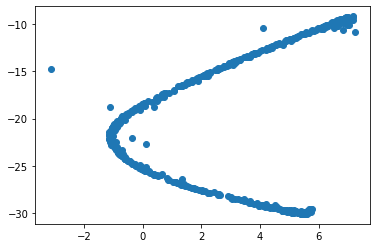

In [38]:
plt.scatter(y_pred['x'], y_pred['y'])